## Synchronized锁

[浅析synchronized锁升级的原理与实现](https://www.cnblogs.com/star95/p/17542850.html)

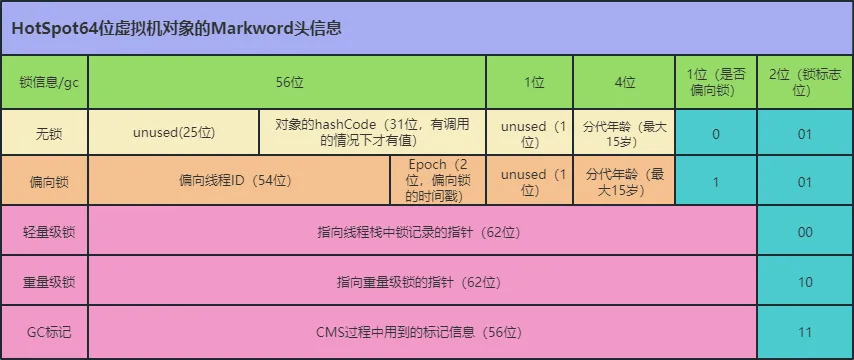

### 锁升级 锁消除 锁粗化

### 锁升级
1. 锁向锁  无锁竞争，有且只有一个线程访问对象锁
2. 轻量级锁 两个线程在竞争锁，通过CAS或自旋等锁
3. 重量级锁 两个以上线程同时抢锁，或线程自旋次数>n

拓展：
- 锁升级是不可逆的(一旦锁升级，直到对象销毁，锁都不会降级);
- 锁升级不是由线程完成的，而是JVM在安全点执行的。
  - 在安全点处，如果线程a持有锁，且同步代码块执行完毕，撤销偏向锁，对象进入无锁状态
  - 如果线程a同步代码块未执行完毕，锁升级为轻量级，stw后，线程a继续执行同步代码
  - 线程b在stw后， 会先cas抢锁，抢不到会短暂自旋，自旋>n,会触发升级为重量级锁

### 锁消除
JIT编译器通过逃逸分析消除不必要的锁
- 某同步内容只有一个线程访问
- 对象单线程可见，不会传递到其他线程
- 没有并发修改对象的可能
- 冗余的锁

### 锁粗化
JIT将多个连续的锁合并为一个更大的锁范围， 以减少加锁和解锁的性能开支。




## 线程池


## 线程间通信

## 死锁

## Volatile的作用

## ThreadLocal的原理和作用

### 最简代码示例

In [ ]:
public class MyThreadLocal<T> {
    // 用一个 Map 存储每个线程对应的变量值
    private final Map<Thread, T> threadValues = new HashMap<>();

    // 获取当前线程的变量值
    public T get() {
        // 获取当前线程
        Thread currentThread = Thread.currentThread();
        return threadValues.get(currentThread);
    }

    // 设置当前线程的变量值
    public void set(T value) {
        // 获取当前线程
        Thread currentThread = Thread.currentThread();
        threadValues.put(currentThread, value);
    }

    // 移除当前线程的变量值
    public void remove() {
        // 获取当前线程
        Thread currentThread = Thread.currentThread();
        threadValues.remove(currentThread);
    }
}

### ThreadLocal有哪些安全问题？

#### ThreadLocal 是线程安全的
每个线程都有一个独立的副本，每个线程也只访问自己的副本。

#### ThreadLocal不能解决的线程安全问题
1. ThreadLocal中存储共享对象
如果在ThreadLocal里put共享对象， 那么其他线程间接修改共享对象， 会导致安全问题

2. 在线程池中使用ThreadLocal，未清理。
在线程池中，线程可能是复用的， 而ThreadLocal的Key是线程ID。

3. ThreadLocal的初始化withInitial不是线程安全的。

如果初始化数据有共享数据，应当手动保证实始化代码的线程安全。
```
private static final ThreadLocal<SimpleDateFormat> threadLocal = ThreadLocal.withInitial(() -> {
    // 复杂的初始化逻辑
    return new SimpleDateFormat("yyyy-MM-dd");
});
```
4. ThreadLocal的内存泄漏问题
ThreadLocal是弱引用， 但其值不是。如果线程仍在运行，而ThreadLocal实例被回收，那么其值可能永远不会被回收，造成内存泄漏。



## AQS与并发工具
ReentrentLock, CountDownLatch, Semaphore都是基于AQS实现的。

### AQS的核心思想


AQS的核心思想是通过一个双端队列CLH和一个volatile state实现的。    

使用CLH来管理等待线程，并通过LockSupport来实现阻塞和唤醒。  
  
**排队**：
当线程抢锁失败， 会将自己封装成一个CLH的Node，加入到队尾。  
**线程唤醒**：当资源释放时， AQS会从队列头部取一个有效Node，唤醒该线程。    

---


### - AQS的独占和共享
**独占**  同一时刻只能有一个线程访问  
典型实现：ReentrentLock

**共享**  同一时间多个线程访问  
典型实现： Semaphore， CountDownLatch，Cyclic Barrier。

---


### - AQS如何保证线程安全
volatile state + CAS操作

---

### - 如何实现重入锁
占锁：state=0，设置为state=1  
重入：state>1, 设置state++  
解锁：state>0, 设置：每次将state--,直到state=0，释放所有锁。


---



### - 公平锁和非公平锁
**公平锁** ：  `ReentrantLock(true)`，CLH队列先进先出。   
**非公平锁**： `ReentrantLock(false)`，操作系统的线程调度来决定哪个线程先获取锁，性能更好。  
Synchronize锁也是非公平锁。

---

### AQS的Condition是如何实现的？
Condition是由AQS实现条件队列，用于实现线程的等待和唤醒机制。  
原理：
-  每个Conditon内部维护一个条件队列（单向）
- 线程调用await(), 释放锁， 并加入条件队列
- 线程调用signal(),将条件队列中的线程转移到CLH，等锁

---

### AQS 源码 极简实现



``` java
public abstract class AbstractQueuedSynchronizer {

    // 状态变量，表示资源的状态（如锁的状态、信号量的许可数等）
    private volatile int state;

    // 等待队列的头节点
    private transient volatile Node head;
    // 等待队列的尾节点
    private transient volatile Node tail;

    // 节点类，表示等待队列中的线程
    static final class Node {
        volatile Node prev; // 前驱节点
        volatile Node next; // 后继节点
        volatile Thread thread; // 等待的线程
        volatile int waitStatus; // 等待状态
    }

    // 尝试获取资源（需子类实现）
    protected boolean tryAcquire(int arg) {
        throw new UnsupportedOperationException();
    }

    // 尝试释放资源（需子类实现）
    protected boolean tryRelease(int arg) {
        throw new UnsupportedOperationException();
    }

    // 获取资源（独占模式）
    public final void acquire(int arg) {
        if (!tryAcquire(arg) && // 尝试获取资源
            acquireQueued(addWaiter(Node.EXCLUSIVE), arg)) { // 获取失败，加入等待队列
            Thread.currentThread().interrupt(); // 如果线程在等待时被中断，重新设置中断标志
        }
    }

    // 释放资源（独占模式）
    public final boolean release(int arg) {
        if (tryRelease(arg)) { // 尝试释放资源
            Node h = head;
            if (h != null && h.waitStatus != 0) {
                unparkSuccessor(h); // 唤醒等待队列中的下一个线程
            }
            return true;
        }
        return false;
    }

    // 将当前线程加入等待队列
    private Node addWaiter(Node mode) {
        Node node = new Node(Thread.currentThread(), mode); // 创建新节点
        Node pred = tail;
        if (pred != null) {
            node.prev = pred;
            if (compareAndSetTail(pred, node)) { // CAS 更新尾节点
                pred.next = node;
                return node;
            }
        }
        enq(node); // 如果 CAS 失败，通过自旋方式加入队列
        return node;
    }

    // 自旋加入队列
    private Node enq(final Node node) {
        for (;;) {
            Node t = tail;
            if (t == null) { // 队列为空，初始化头节点
                if (compareAndSetHead(new Node())) {
                    tail = head;
                }
            } else {
                node.prev = t;
                if (compareAndSetTail(t, node)) { // CAS 更新尾节点
                    t.next = node;
                    return t;
                }
            }
        }
    }

    // 在队列中等待获取资源
    final boolean acquireQueued(final Node node, int arg) {
        boolean interrupted = false;
        for (;;) {
            final Node p = node.predecessor();
            if (p == head && tryAcquire(arg)) { // 如果前驱是头节点，并且成功获取资源
                setHead(node); // 将当前节点设置为头节点
                p.next = null; // 帮助 GC
                return interrupted;
            }
            if (shouldParkAfterFailedAcquire(p, node)) { // 检查是否需要阻塞
                interrupted |= parkAndCheckInterrupt(); // 阻塞当前线程
            }
        }
    }

    // 唤醒等待队列中的下一个线程
    private void unparkSuccessor(Node node) {
        Node s = node.next;
        if (s != null && s.thread != null) {
            LockSupport.unpark(s.thread); // 唤醒线程
        }
    }

    // CAS 操作：更新头节点
    private final boolean compareAndSetHead(Node update) {
        return unsafe.compareAndSwapObject(this, headOffset, null, update);
    }

    // CAS 操作：更新尾节点
    private final boolean compareAndSetTail(Node expect, Node update) {
        return unsafe.compareAndSwapObject(this, tailOffset, expect, update);
    }
}
```



### CyclicBarrier

所有线程在等待点会合，会合后共同完成一个任务。  
和CountDownLatch的区别是可以多回合(多阶段)会合。  


简易实现代码：
```java
public class CyclicBarrier {
    // 用于保护屏障点的锁
    private final ReentrantLock lock = new ReentrantLock();
    // 用于线程等待的条件变量
    private final Condition trip = lock.newCondition();
    // 参与的线程数
    private final int parties;
    // 当所有线程到达屏障点时执行的回调任务
    private final Runnable barrierCommand;
    // 当前代（Generation）
    private Generation generation = new Generation();
    // 尚未到达屏障点的线程数
    private int count;

    public int await() {
        try {
            return dowait(false, 0L);
        } catch (TimeoutException toe) {
            throw new Error(toe); // cannot happen
        }
    }

    private int dowait(boolean timed, long nanos){
    final ReentrantLock lock = this.lock;
    lock.lock();
    try {
        final Generation g = generation;

        int index = --count;
        if (index == 0) {  // 所有线程都已到达屏障点
            boolean ranAction = false;
            try {
                final Runnable command = barrierCommand;
                if (command != null)
                    command.run(); // 执行回调任务
                ranAction = true;
                nextGeneration(); // 重置屏障点
                return 0;
            } finally {
                if (!ranAction)
                    breakBarrier();
            }
        }

        // 等待其他线程到达屏障点
        for (;;) {
            try {
                if (!timed)
                    trip.await();
                else if (nanos > 0L)
                    nanos = trip.awaitNanos(nanos);
            } catch (InterruptedException ie) {
                // ,,, 其他代码
            }

        }
    } finally {
        lock.unlock();
    }
    }
}
```


使用示例代码：



In [ ]:
```
int parties = 3;  // 参与的线程数量
CyclicBarrier barrier = new CyclicBarrier(parties, () -> {
    System.out.println("所有线程会合，开始共事");
});

// 模拟多阶段任务: 两个阶段
for (int stage = 1; stage <= 2; stage++) {  // 两个阶段
    System.out.println("Stage " + stage + " starts.");
    final int s = stage;
    for (int i = 0; i < parties; i++) {
        new Thread(() -> {
            try {
                // 每个线程做一些工作
                System.out.println(Thread.currentThread().getName() + " is working.");
                Thread.sleep(1000); // 模拟工作
                barrier.await(); // 等待其他线程
                System.out.println(Thread.currentThread().getName() + " has finished stage " + s + ".");
            } catch (Exception e) {
                e.printStackTrace();
            }
        }).start();
    }
}
```

### Semaphore
常用于限制资源请求的线程数量， 比如数据库连接池，并发请求的数量。  
通过计数器state来限制线程数量。   
示例代码：

In [ ]:
// 创建一个信号量，允许最多 2 个线程同时访问资源
Semaphore semaphore = new Semaphore(2);

// 创建 5 个线程来模拟对共享资源的访问
for (int i = 0; i < 5; i++) {
    final int threadNum = i;
    new Thread(() -> {
        try {
            // 获取信号量，表示一个线程获取了资源，如果线程数量已占满，会阻塞等待
            semaphore.acquire(); // state --
            System.out.println("Thread " + threadNum + " is accessing the resource.");
            // 模拟线程操作资源
            Thread.sleep(1000);
            System.out.println("Thread " + threadNum + " has finished accessing the resource.");
        } catch (InterruptedException e) {
            Thread.currentThread().interrupt();
        } finally {
            // 释放信号量，允许其他线程获取资源
            semaphore.release(); // state++
        }
    }).start();
}